## Import Libraries 

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

## Set The device
Use cuda if available otherwise use cpu

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

Define dataset

In [3]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
dataset = FashionMNIST()
dataset[0][0]

In [5]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

**** Create Discriminator Model ****

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784) # batch_size x 784
        c = self.label_emb(labels) # batch_size x 10
        x = torch.cat([x, c], 1)   # batch_size x 794
        out = self.model(x)        # batch_size x 1
        return out.squeeze()       # batch_size

**Create Generator Model**

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)      # batch_size x 100
        c = self.label_emb(labels)      
        x = torch.cat([z, c], 1)        # batch_size x 110
        out = self.model(x)             # batch_size x 784
        return out.view(x.size(0), 28, 28) # batch_size x 28 x 28

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

Create optimizer for both Discriminator and Generator

In [9]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters() , lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters() , lr=1e-4)

Training function of generater model

In [10]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

Training function of generater model

In [11]:
def discriminator_train_step(batch_size , discriminator , generator , d_optimizer , criterion , real_image , labels):
    d_optimizer.zero_grad()
    
    # train with real images
    real_validity = discriminator(real_images , labels)
    real_loss = criterion(real_validity , Variable(torch.ones(batch_size).to(device)))
    
    # train with fake images
    z = Variable(torch.randn(batch_size ,100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0,10,batch_size))).to(device)
    fake_images = generator(z , fake_labels)
    fake_validity = discriminator(fake_images , fake_labels)
    fake_loss = criterion(fake_validity , Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

Train the model

Starting epoch 0...
g_loss: 5.950924873352051 , d_loss: 0.1348353624343872 
(92, 92, 3)


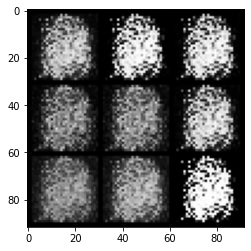

Starting epoch 1...
g_loss: 6.1699700355529785 , d_loss: 0.11003700643777847 
(92, 92, 3)


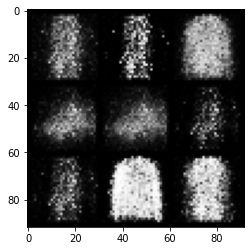

Starting epoch 2...
g_loss: 2.860029697418213 , d_loss: 0.4404706358909607 
(92, 92, 3)


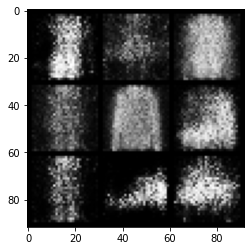

Starting epoch 3...
g_loss: 2.679941415786743 , d_loss: 0.4172601103782654 
(92, 92, 3)


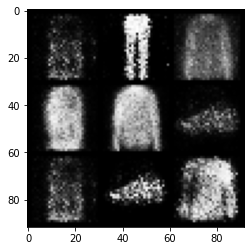

Starting epoch 4...
g_loss: 1.7125753164291382 , d_loss: 0.6881697177886963 
(92, 92, 3)


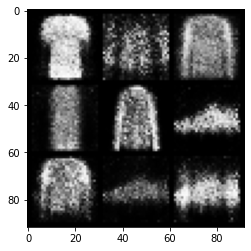

Starting epoch 5...
g_loss: 2.2064146995544434 , d_loss: 0.5561404824256897 
(92, 92, 3)


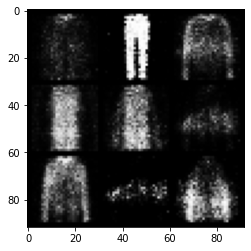

Starting epoch 6...
g_loss: 2.4338161945343018 , d_loss: 0.46457549929618835 
(92, 92, 3)


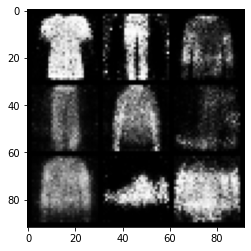

Starting epoch 7...
g_loss: 2.373302459716797 , d_loss: 0.6299788951873779 
(92, 92, 3)


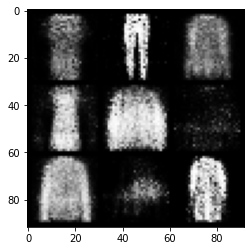

Starting epoch 8...
g_loss: 2.199674367904663 , d_loss: 0.6556060314178467 
(92, 92, 3)


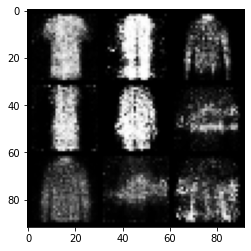

Starting epoch 9...
g_loss: 2.0413737297058105 , d_loss: 0.8280607461929321 
(92, 92, 3)


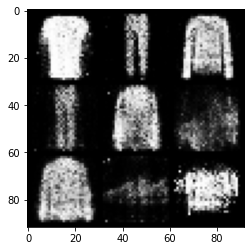

Starting epoch 10...
g_loss: 1.6568821668624878 , d_loss: 0.758568286895752 
(92, 92, 3)


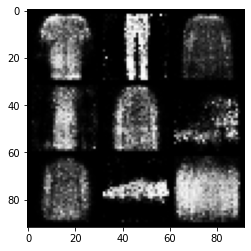

Starting epoch 11...
g_loss: 2.422260046005249 , d_loss: 0.8154873847961426 
(92, 92, 3)


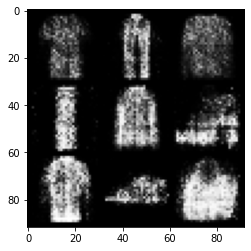

Starting epoch 12...
g_loss: 1.6014888286590576 , d_loss: 1.0471251010894775 
(92, 92, 3)


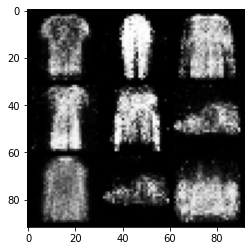

Starting epoch 13...
g_loss: 1.2980315685272217 , d_loss: 0.7580604553222656 
(92, 92, 3)


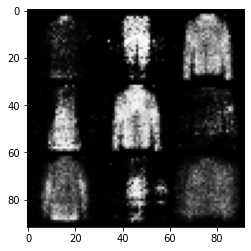

Starting epoch 14...
g_loss: 1.9641906023025513 , d_loss: 0.7254914045333862 
(92, 92, 3)


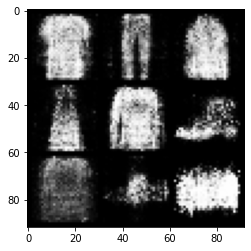

Starting epoch 15...
g_loss: 1.537719488143921 , d_loss: 0.7951195240020752 
(92, 92, 3)


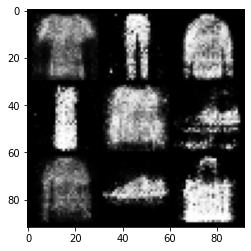

Starting epoch 16...
g_loss: 1.5360075235366821 , d_loss: 1.0958162546157837 
(92, 92, 3)


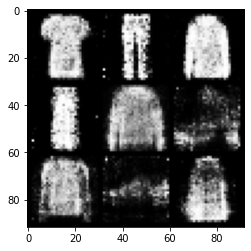

Starting epoch 17...
g_loss: 1.351426362991333 , d_loss: 0.9989432096481323 
(92, 92, 3)


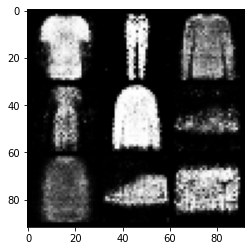

Starting epoch 18...
g_loss: 1.133972406387329 , d_loss: 0.8905242681503296 
(92, 92, 3)


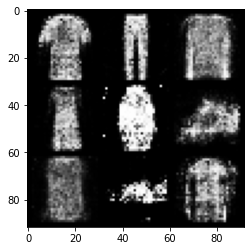

Starting epoch 19...
g_loss: 1.4879825115203857 , d_loss: 0.8207098245620728 
(92, 92, 3)


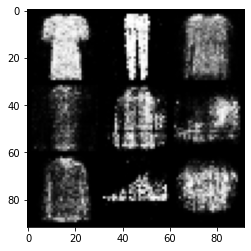

Starting epoch 20...
g_loss: 1.2549749612808228 , d_loss: 1.115060567855835 
(92, 92, 3)


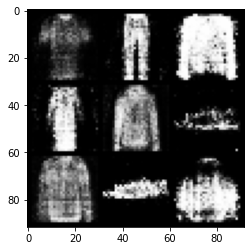

Starting epoch 21...
g_loss: 1.3894786834716797 , d_loss: 0.8464479446411133 
(92, 92, 3)


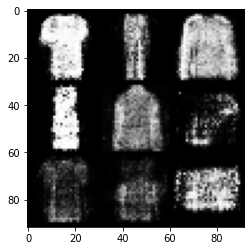

Starting epoch 22...
g_loss: 1.4051874876022339 , d_loss: 0.7045567631721497 
(92, 92, 3)


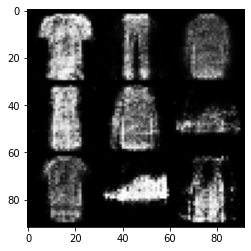

Starting epoch 23...
g_loss: 1.1614766120910645 , d_loss: 0.8969136476516724 
(92, 92, 3)


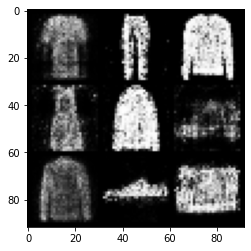

Starting epoch 24...
g_loss: 1.1760088205337524 , d_loss: 1.0977048873901367 
(92, 92, 3)


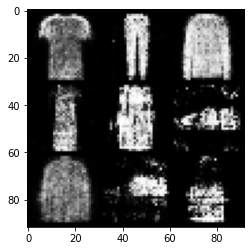

Starting epoch 25...
g_loss: 0.9589515924453735 , d_loss: 1.2033199071884155 
(92, 92, 3)


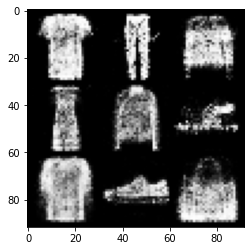

Starting epoch 26...
g_loss: 1.2475847005844116 , d_loss: 0.8434359431266785 
(92, 92, 3)


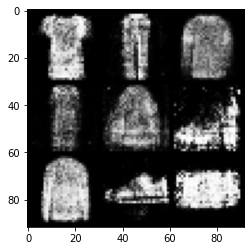

Starting epoch 27...
g_loss: 1.0222373008728027 , d_loss: 1.0949026346206665 
(92, 92, 3)


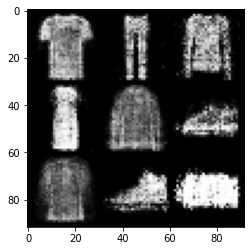

Starting epoch 28...
g_loss: 0.8704451322555542 , d_loss: 1.2120447158813477 
(92, 92, 3)


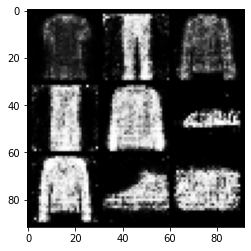

Starting epoch 29...
g_loss: 1.2139194011688232 , d_loss: 1.1376252174377441 
(92, 92, 3)


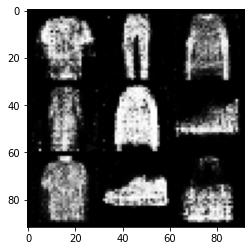

In [12]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print("Starting epoch {}...".format(epoch))
    for i , (images , labels) in enumerate(data_loader):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(batch_size , discriminator , generator , d_optimizer , criterion , real_images , labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    generator.eval()
    print('g_loss: {} , d_loss: {} '.format(g_loss , d_loss))
    z = Variable(torch.randn(9,100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(9))).to(device)
    sample_images = generator(z , labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    print(grid.shape)
    plt.imshow(grid)
    plt.show()

torch.Size([100, 1, 28, 28])
torch.Size([3, 302, 302])
(302, 302, 3)


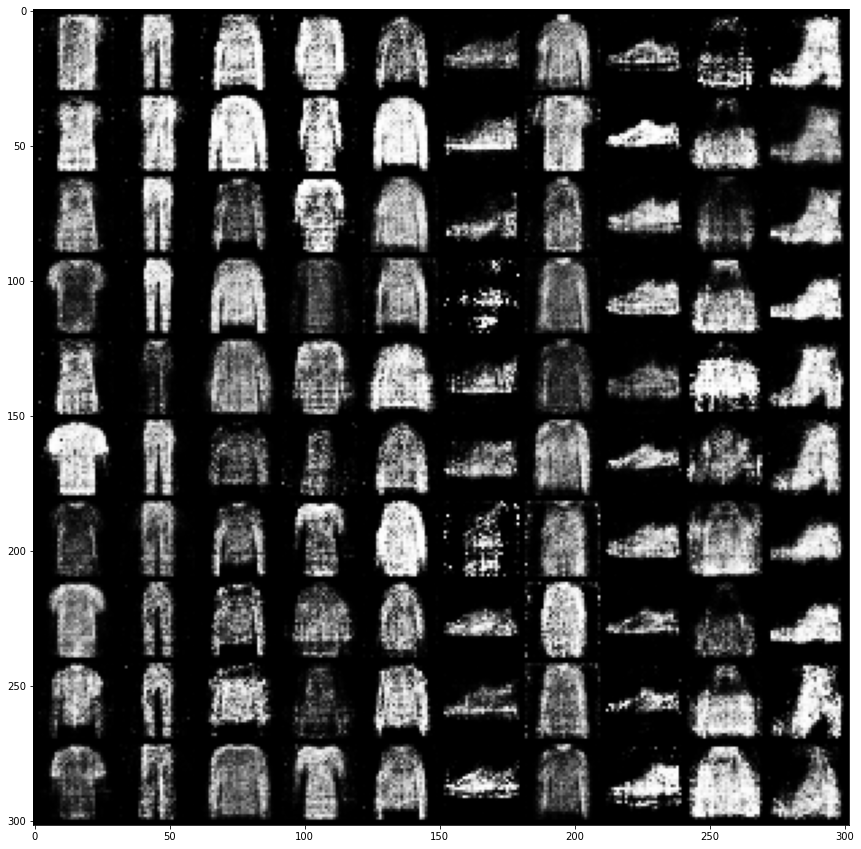

In [13]:
z = Variable(torch.randn(100,100)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).to(device)
sample_images = generator(z , labels).unsqueeze(1).data.cpu()
print(sample_images.shape)
print(make_grid(sample_images, nrow=10, normalize=True).shape)
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
print(grid.shape)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
